In [2]:
import numpy as np
import matplotlib.pylab as plt
from glob import glob
import librosa
from scipy.stats import ttest_ind
import librosa.display
import seaborn as sns
import pandas as pd
import json

In [3]:
# Load an audio file
audio_files_east_coast = glob('./east_coast/*.mp3')
audio_files_west_coast = glob('./west_coast/*.mp3')

NUMBER_OF_MFCCs = 20

In [4]:
# Utility functions

def compute_mfccs(audio_path, n_mfcc=20, compute_avg=True):
    # Load audio file
    y, sr = librosa.load(audio_path)
    
    # Compute MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    
    if(compute_avg):
        # Average over time to get aggregated MFCCs -> Shape for one file: (20, )
        avg_mfccs = np.mean(mfccs, axis=1)
        return avg_mfccs
    else:
        return mfccs

def plot_mfcc_distributions(mfccs_list_1, mfccs_list_2, legend, title):
    plt.figure(figsize=(16, 8))
    sns.histplot(mfccs_list_1, bins=20, kde=True, color='red', alpha=0.5)
    sns.histplot(mfccs_list_2, bins=20, kde=True, color='yellow', alpha=0.5)
    plt.xlabel('MFCC Values')
    plt.ylabel('Frequency')
    plt.legend(labels=legend)
    plt.title(title)
    plt.show()

# Fill a numpy array to have the desired length with 0s
def pad_with_zeros(array, final_length):
    padding_length = final_length - len(array)
    if padding_length > 0:
        array = np.pad(array, (0, padding_length), 'constant', constant_values=(0,))
    return array

In [5]:
# ------------EAST-----------------
# List to store aggregated MFCCs and labels
avg_mfccs_list_east_coast = []
for file in audio_files_east_coast:
    avg_mfccs = compute_mfccs(file, NUMBER_OF_MFCCs).reshape(1, NUMBER_OF_MFCCs)
    avg_mfccs_list_east_coast.append(avg_mfccs)

east_coast_mfccs = np.vstack(avg_mfccs_list_east_coast)
east_coast_mfccs_mean = np.mean(east_coast_mfccs, axis=1)
east_coast_mfccs_std = np.std(east_coast_mfccs, axis=1)

# -------------WEST----------------
# List to store aggregated MFCCs and labels
avg_mfccs_list_west_coast = []
for file in audio_files_west_coast:
    mfccs = compute_mfccs(file, NUMBER_OF_MFCCs).reshape(1, NUMBER_OF_MFCCs)
    avg_mfccs_list_west_coast.append(mfccs)

west_coast_mfccs = np.vstack(avg_mfccs_list_west_coast)
west_coast_mfccs_mean = np.mean(west_coast_mfccs, axis=1)
west_coast_mfccs_std = np.std(west_coast_mfccs, axis=1)

<h2>Statistical Testing</h2>

In [6]:
# Test for Mean
t_stat_mean, p_value_mean = ttest_ind(east_coast_mfccs_mean, west_coast_mfccs_mean)
print(f"Mean MFCCs: p-value = {p_value_mean}")

# Test for Std
t_stat_std, p_value_std = ttest_ind(east_coast_mfccs_std, west_coast_mfccs_std)
print(f"Std of MFCCs: p-value = {p_value_std}")

Mean MFCCs: p-value = 0.1903964378275009
Std of MFCCs: p-value = 0.004638282520910263


<b>It seems that the standard deviation difference between our east coast and west coast data is significant. The Mean is not.</b>

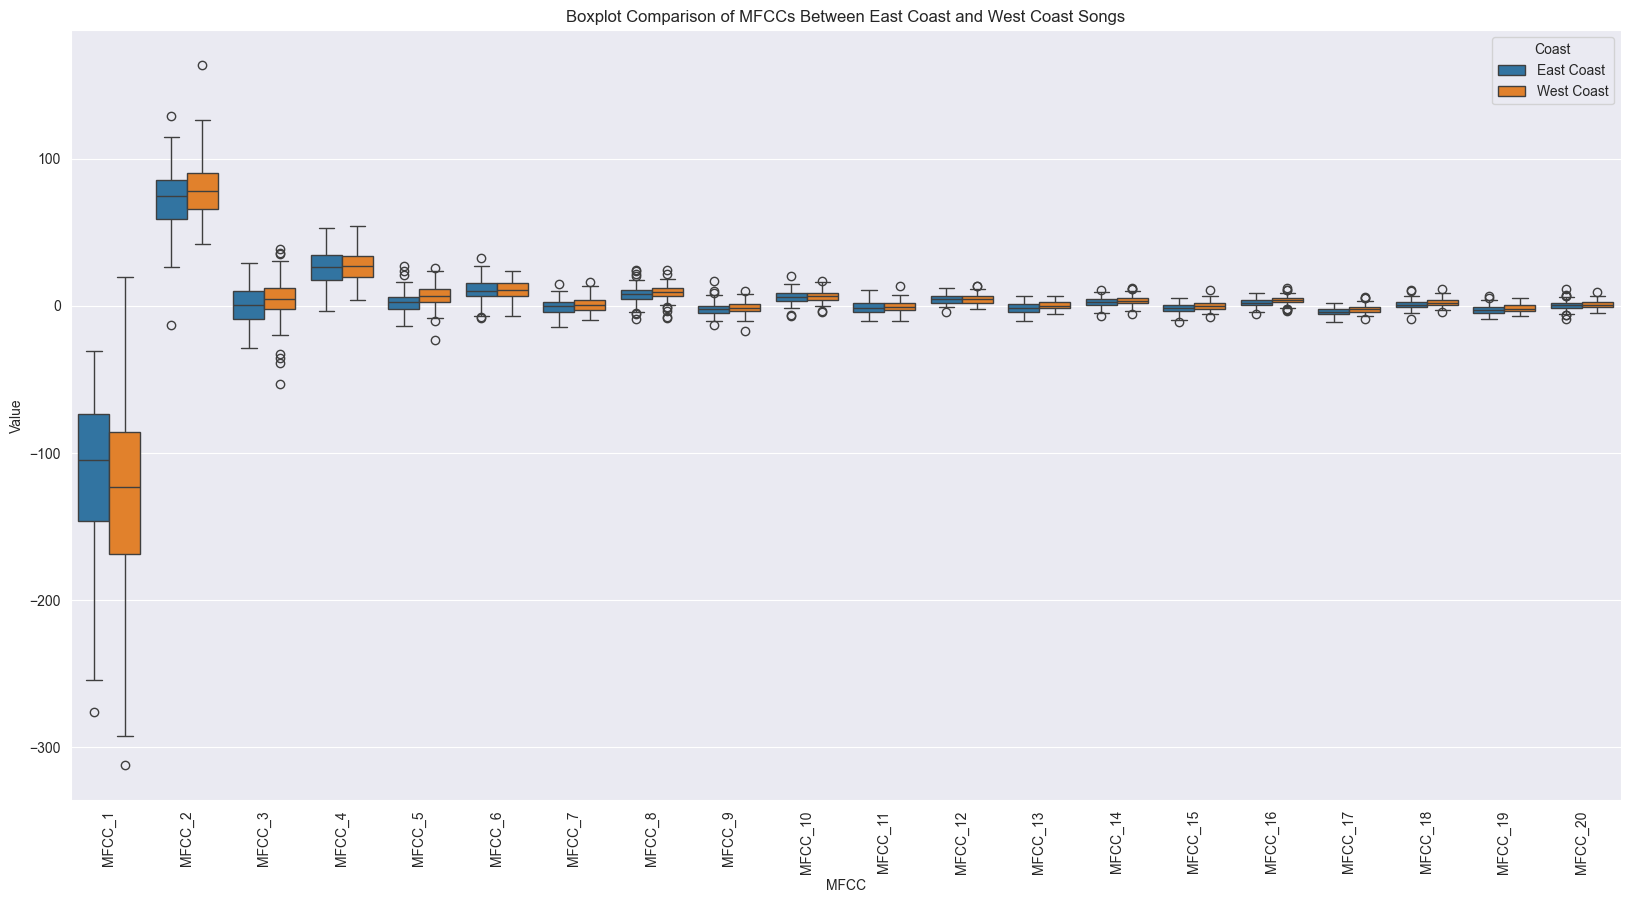

In [26]:
df_east = pd.DataFrame(east_coast_mfccs, columns=[f'MFCC_{i+1}' for i in range(NUMBER_OF_MFCCs)])
df_east['Coast'] = 'East Coast'
df_west = pd.DataFrame(west_coast_mfccs, columns=[f'MFCC_{i+1}' for i in range(NUMBER_OF_MFCCs)])
df_west['Coast'] = 'West Coast'

df = pd.concat([df_east, df_west])
df_melted = df.melt(id_vars='Coast', var_name='MFCC', value_name='Value')

# Create the boxplot
plt.figure(figsize=(20, 10))
sns.boxplot(x='MFCC', y='Value', hue='Coast', data=df_melted)
plt.title('Boxplot Comparison of MFCCs Between East Coast and West Coast Songs')
plt.xticks(rotation=90)
plt.show()

<b>It seems that it worth checking the first MFCC over time</b>

In [8]:
# ------------EAST-----------------
# List to store aggregated MFCCs and labels
mfccs_1_list_east_coast = []
for file in audio_files_east_coast:
    mfccs_1 = compute_mfccs(file, 1, False)
    mfccs_1_list_east_coast.append(mfccs_1)

# -------------WEST----------------
# List to store aggregated MFCCs and labels
mfccs_1_list_west_coast = []
for file in audio_files_west_coast:
    mfccs_1 = compute_mfccs(file, 1, False)
    mfccs_1_list_west_coast.append(mfccs_1)

In [9]:
max_length_east = max(mfcc.shape[1] for mfcc in mfccs_1_list_east_coast)
max_length_west = max(mfcc.shape[1] for mfcc in mfccs_1_list_west_coast)
max_length = max(max_length_west, max_length_east)

In [17]:
padded_mfccs_east_list = [pad_with_zeros(np.squeeze(mfcc), max_length) for mfcc in mfccs_1_list_east_coast]
padded_mfccs_west_list = [pad_with_zeros(np.squeeze(mfcc), max_length) for mfcc in mfccs_1_list_west_coast]

In [22]:
east_coast_mfccs_1 = np.vstack(padded_mfccs_east_list)
west_coast_mfccs_1 = np.vstack(padded_mfccs_west_list)
east_coast_avg_mfccs_1 = np.mean(east_coast_mfccs_1, axis=0)
west_coast_avg_mfccs_1 = np.mean(west_coast_mfccs_1, axis=0)

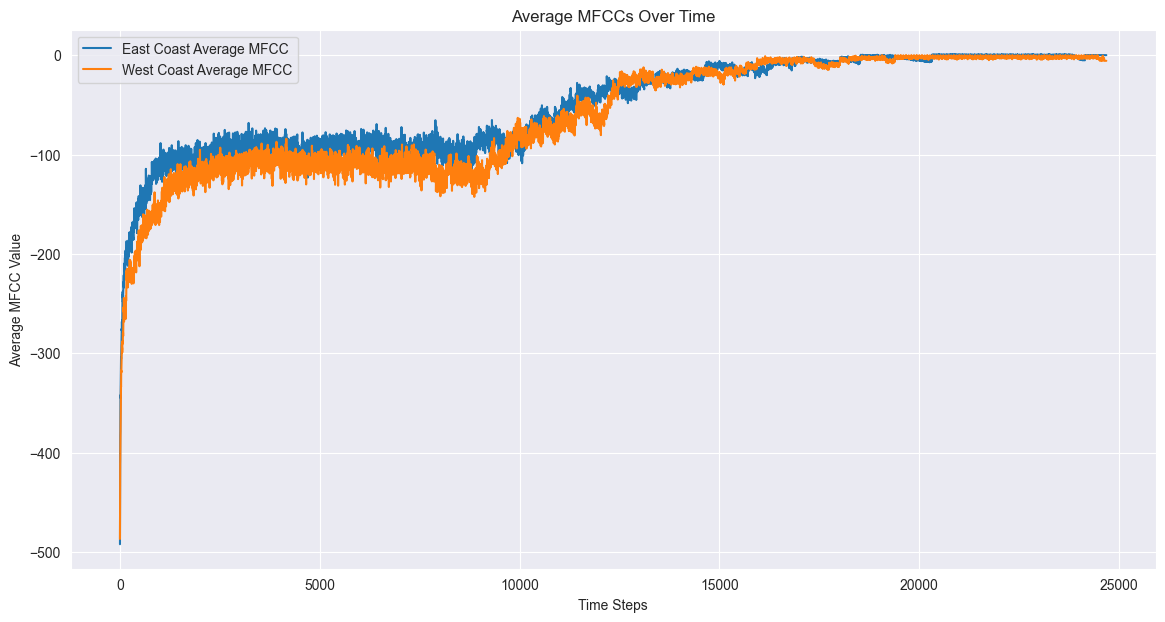

In [24]:
plt.figure(figsize=(14, 7))
plt.plot(east_coast_avg_mfccs_1, label='East Coast Average MFCC')
plt.plot(west_coast_avg_mfccs_1, label='West Coast Average MFCC')
plt.title('Average MFCCs Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Average MFCC Value')
plt.legend()
plt.show()

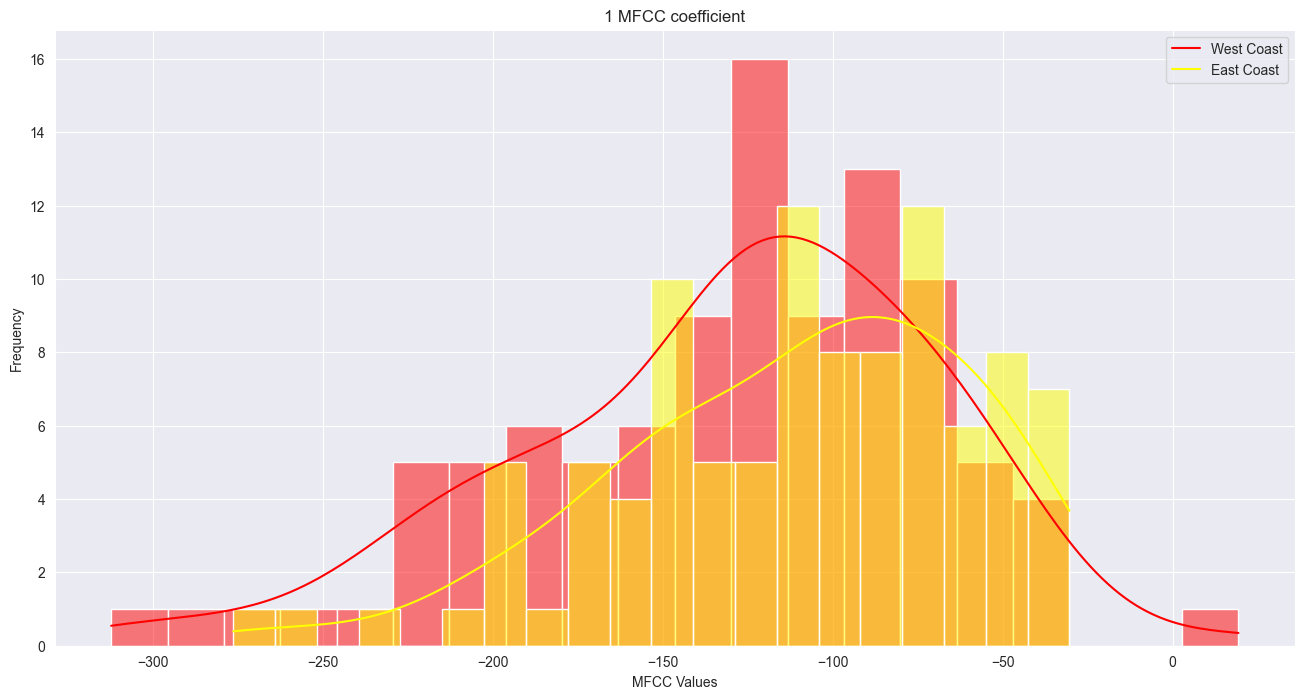

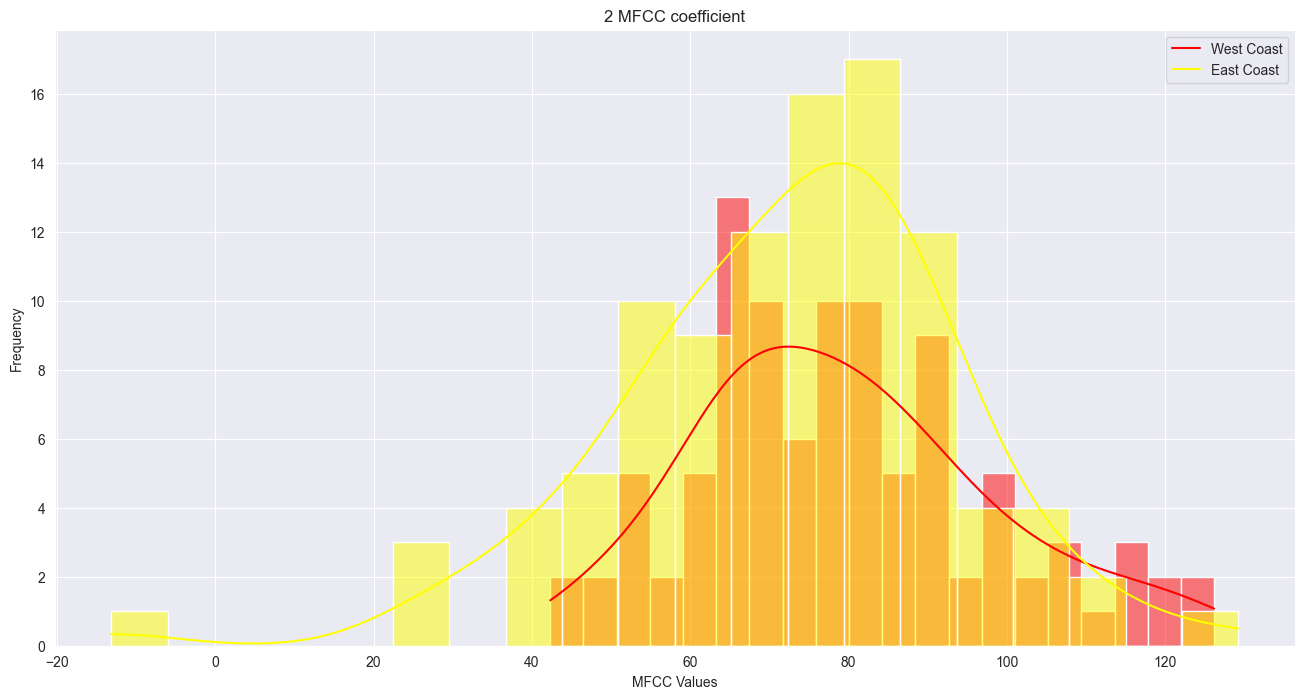

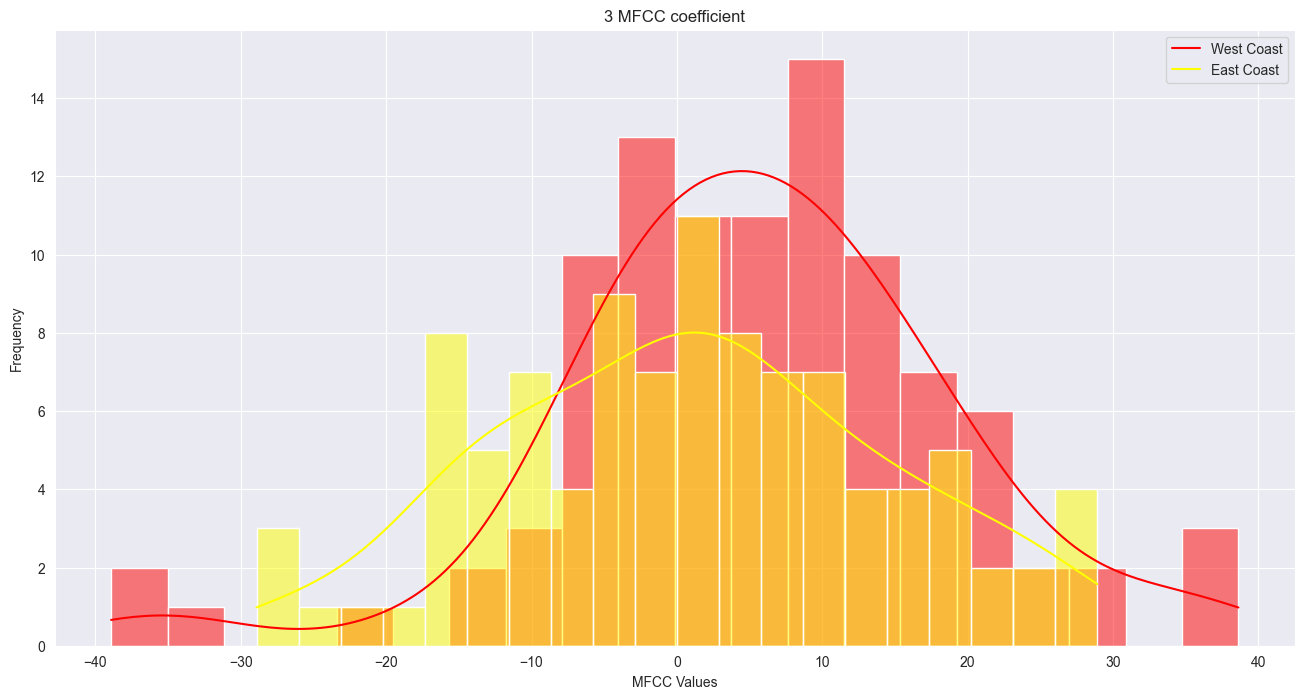

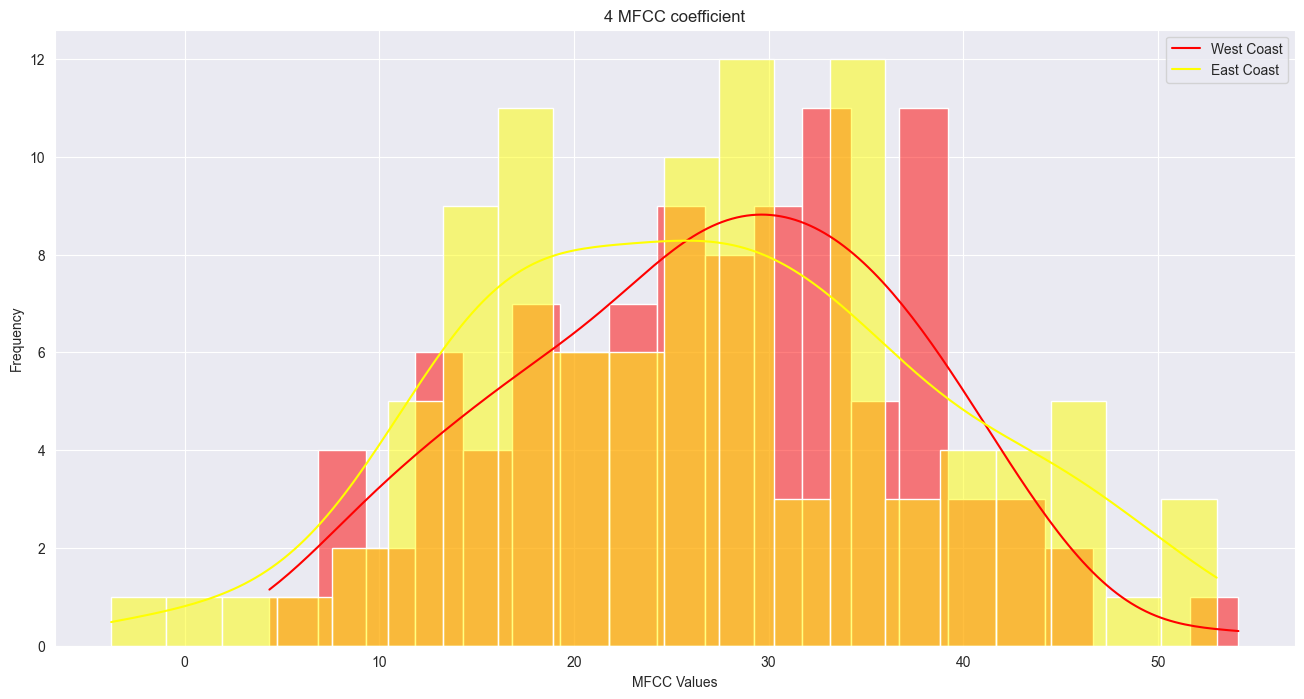

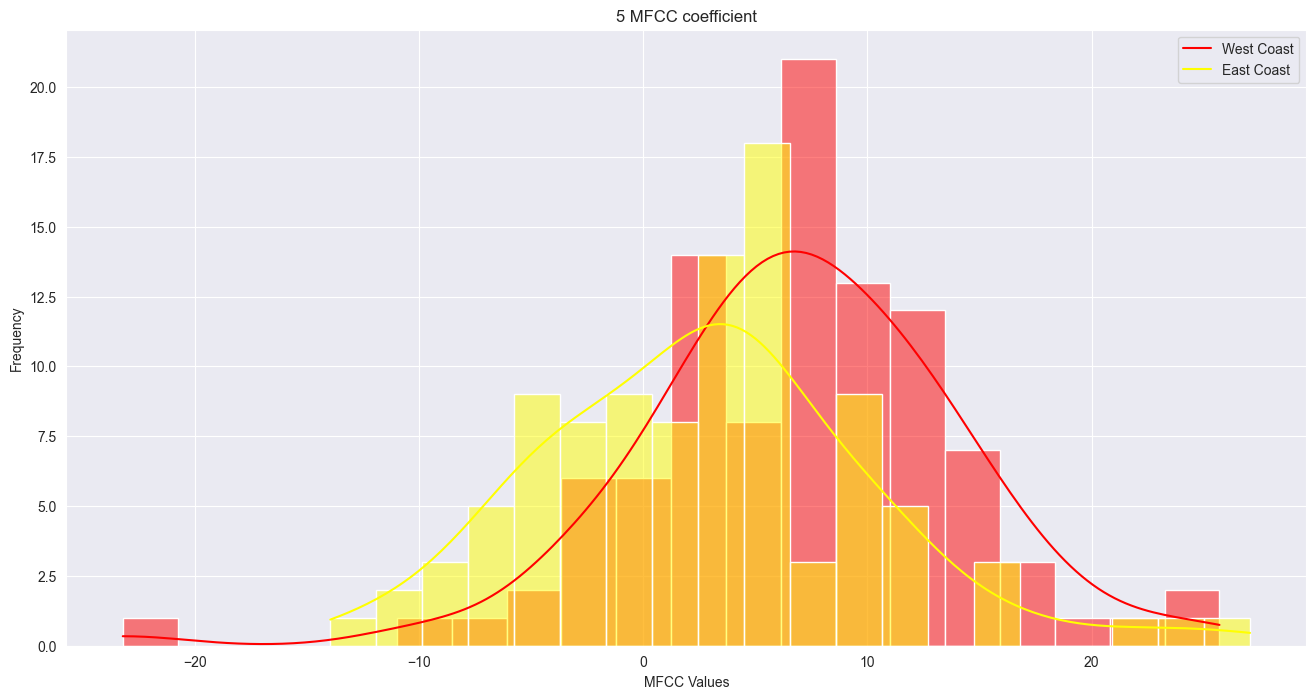

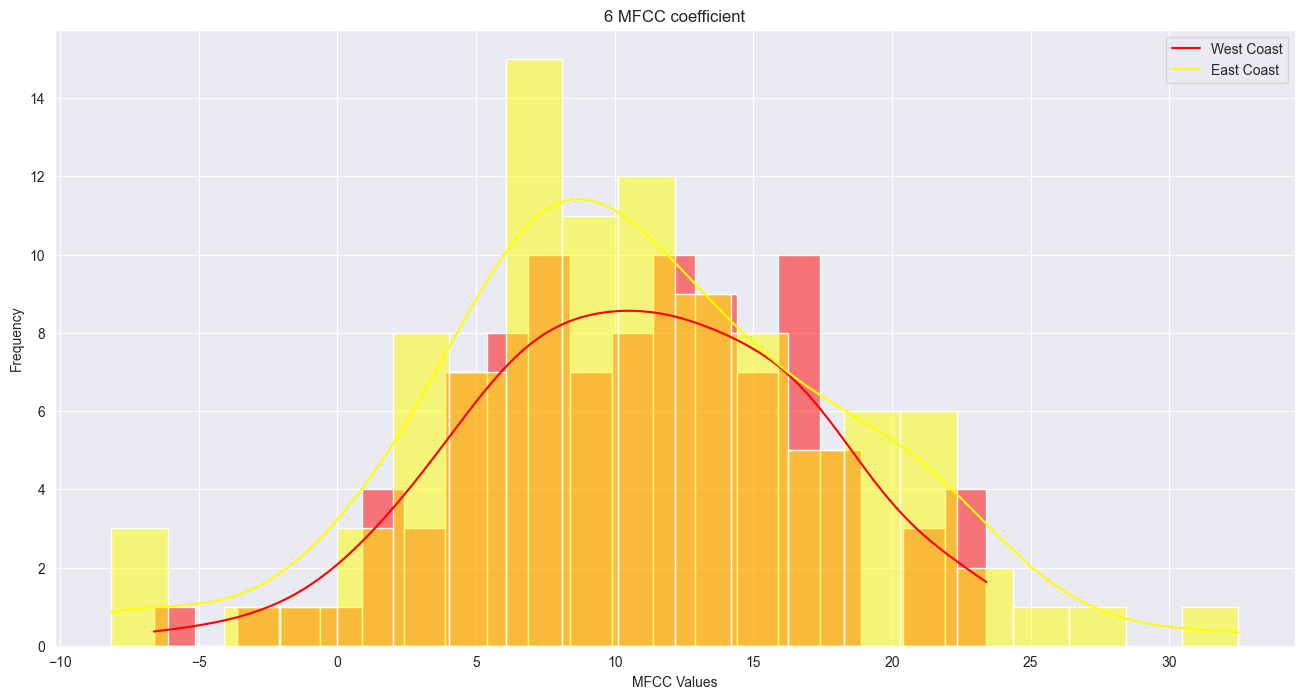

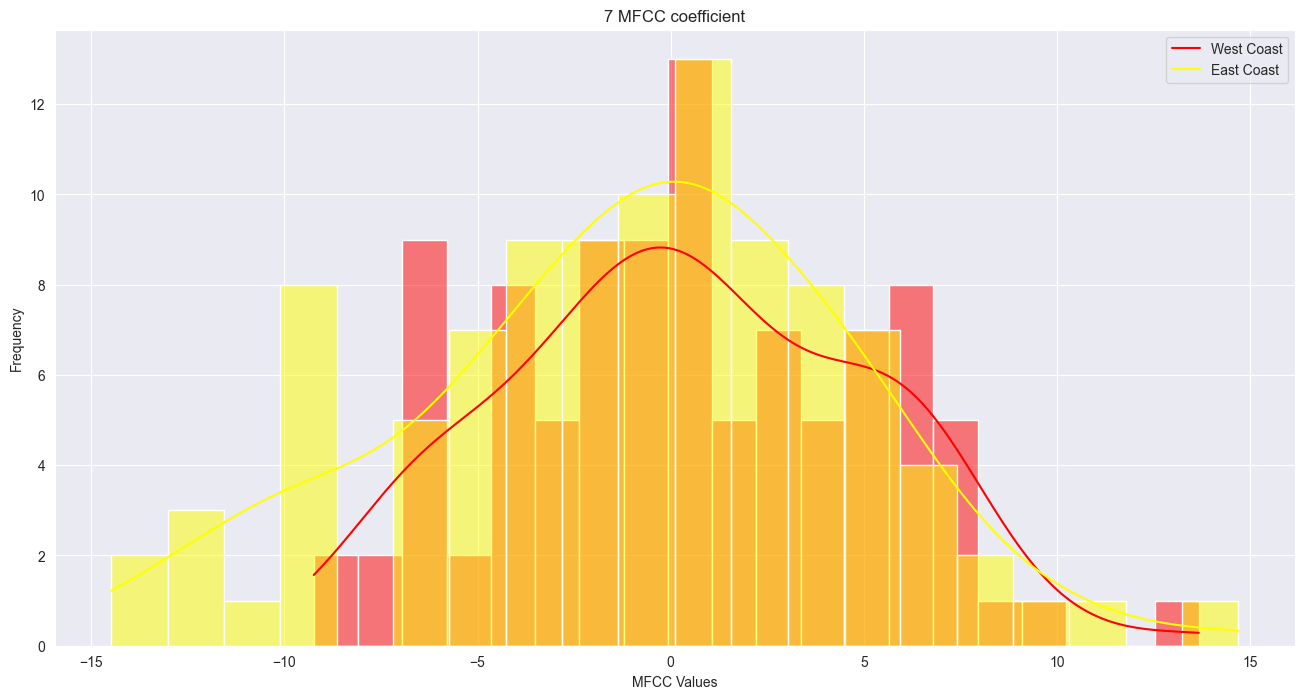

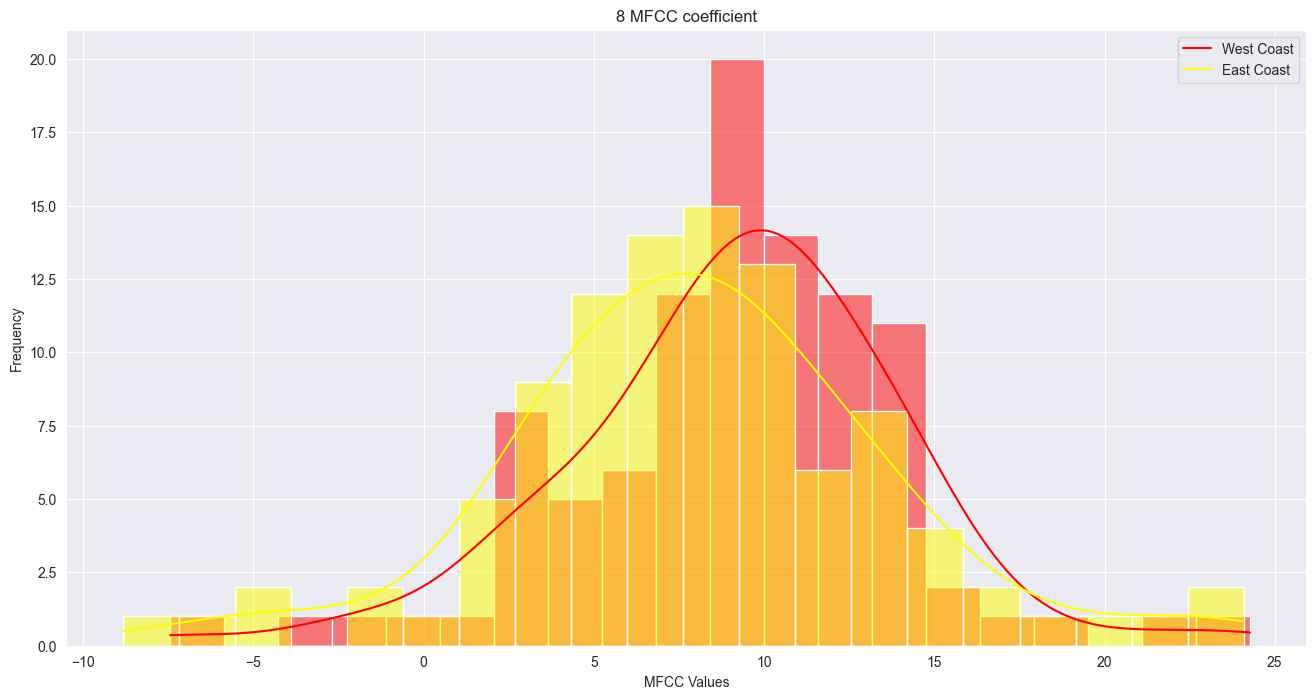

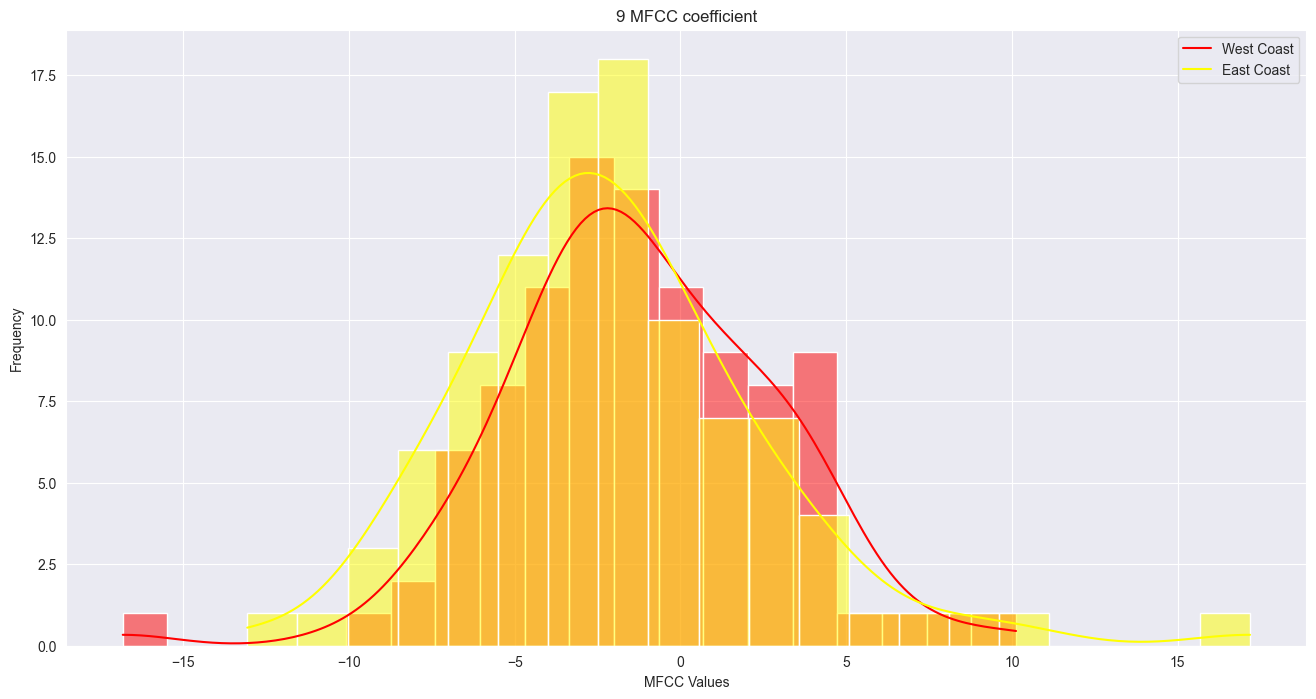

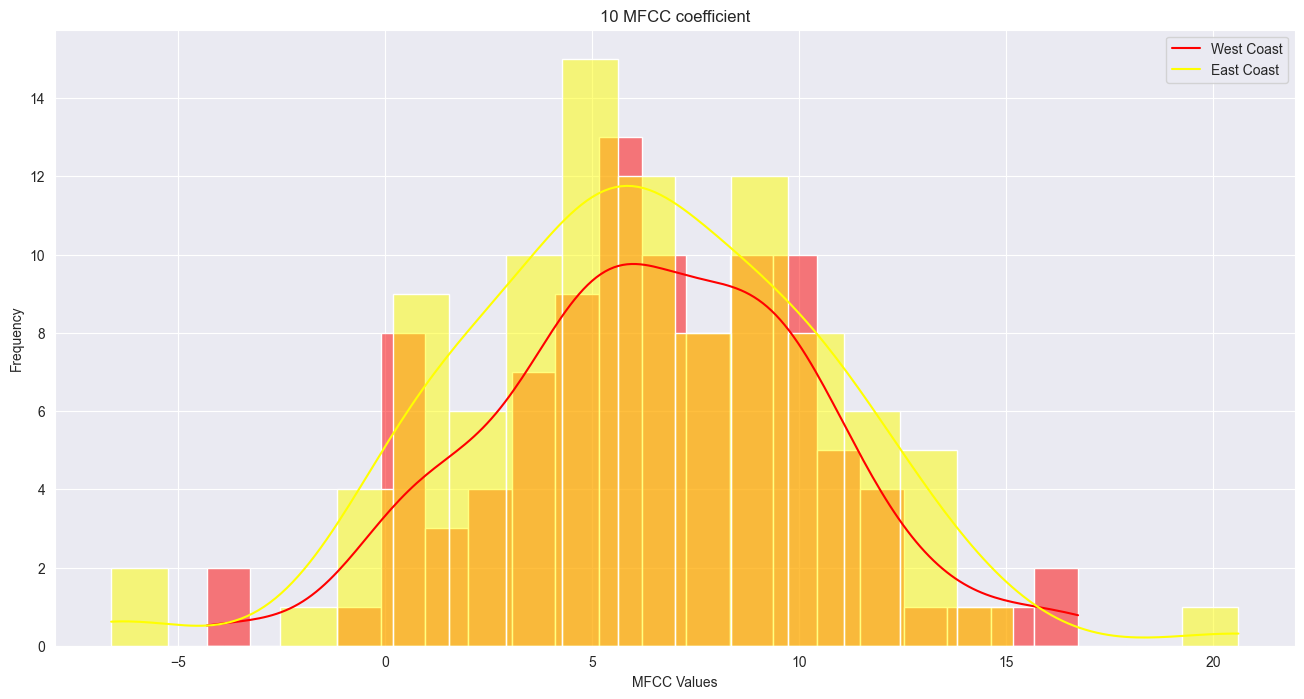

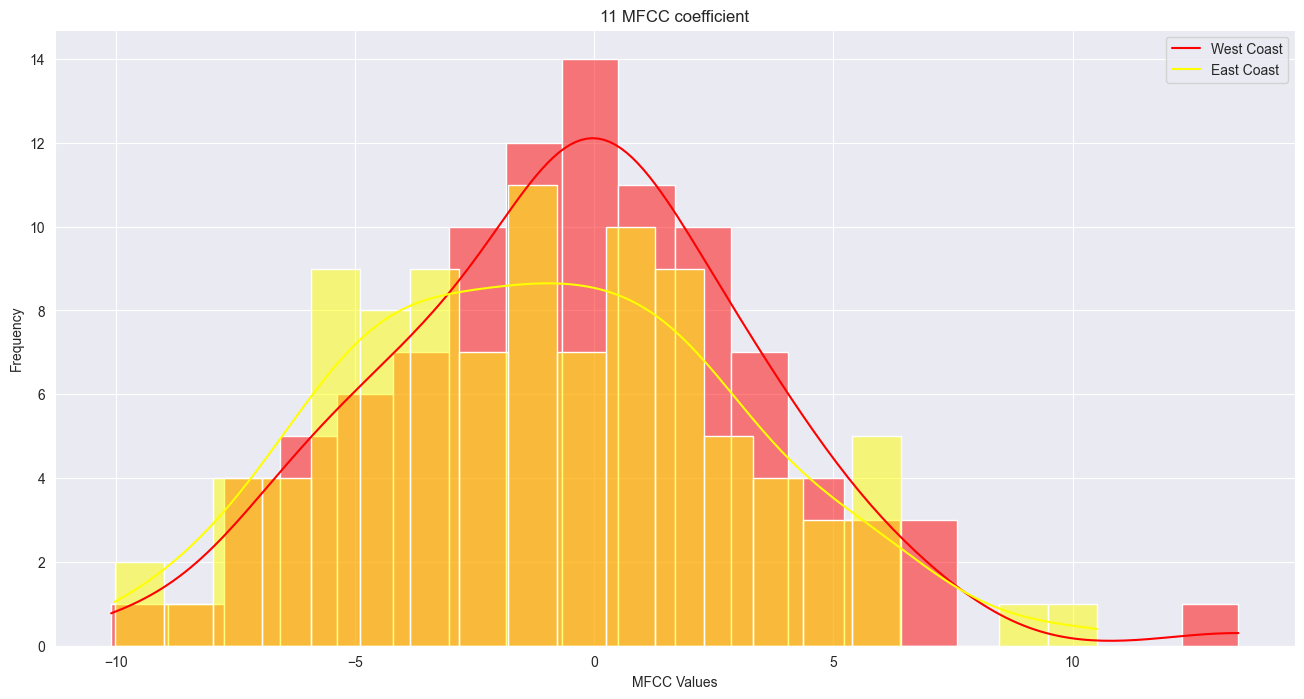

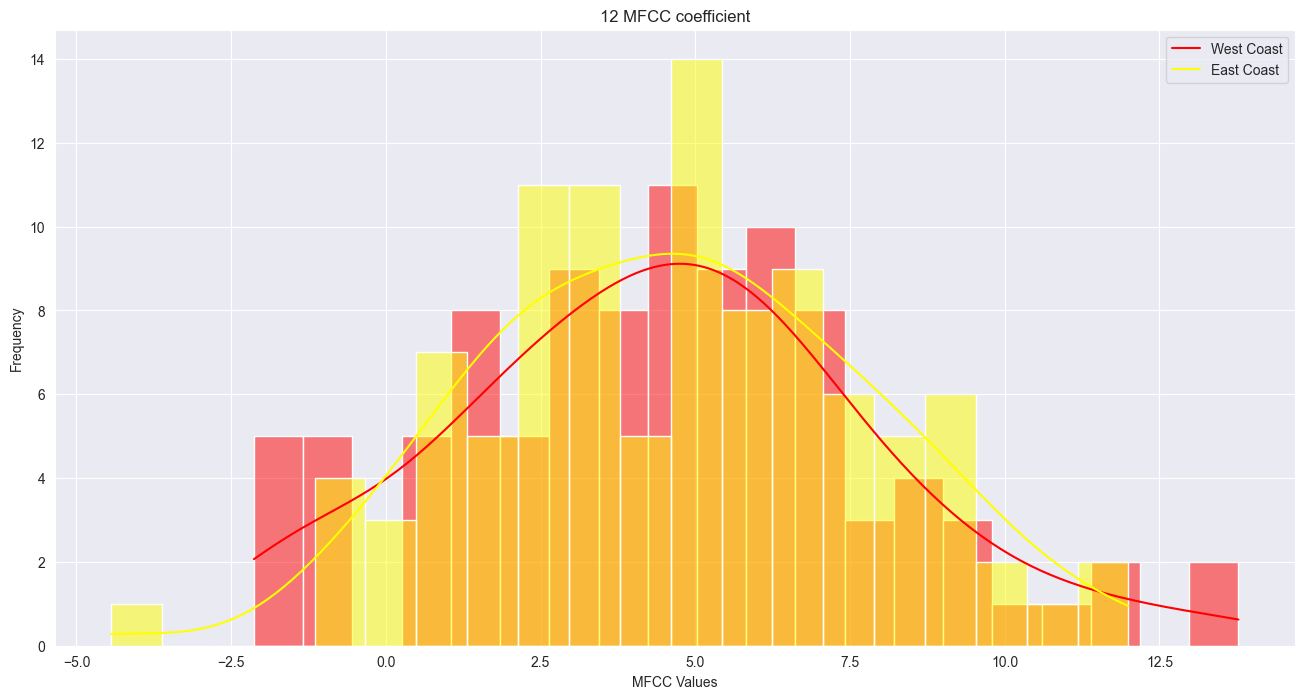

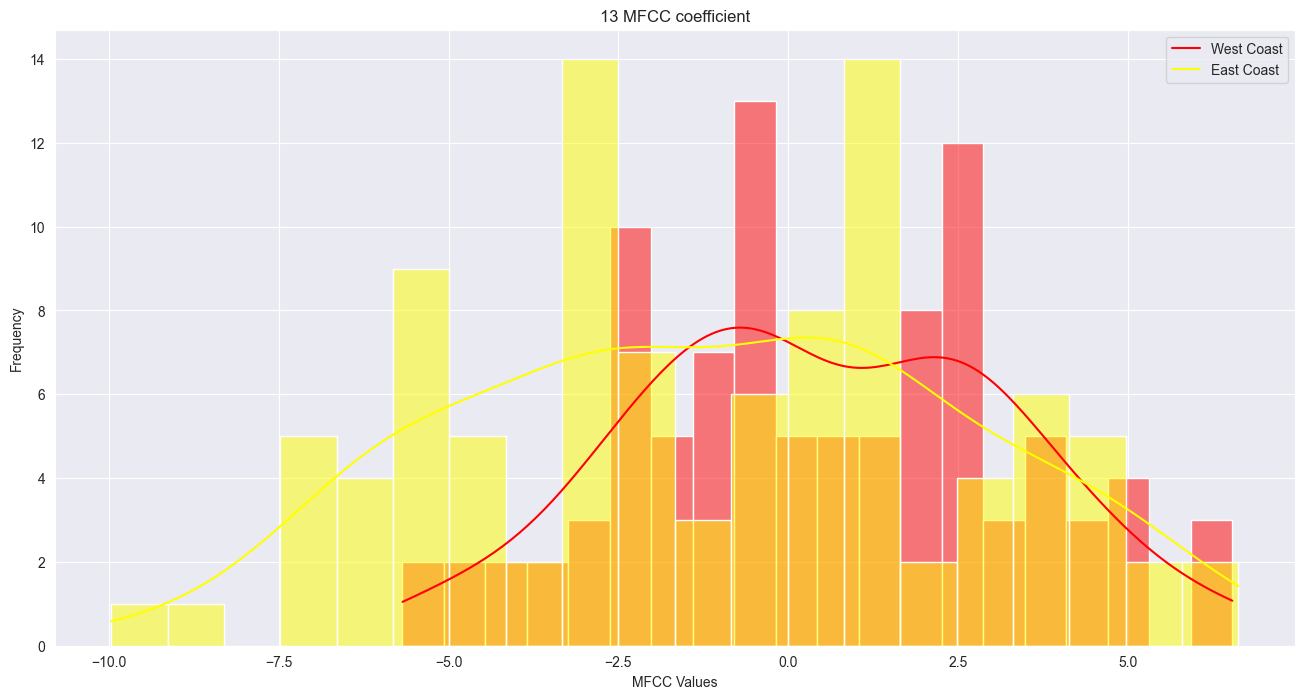

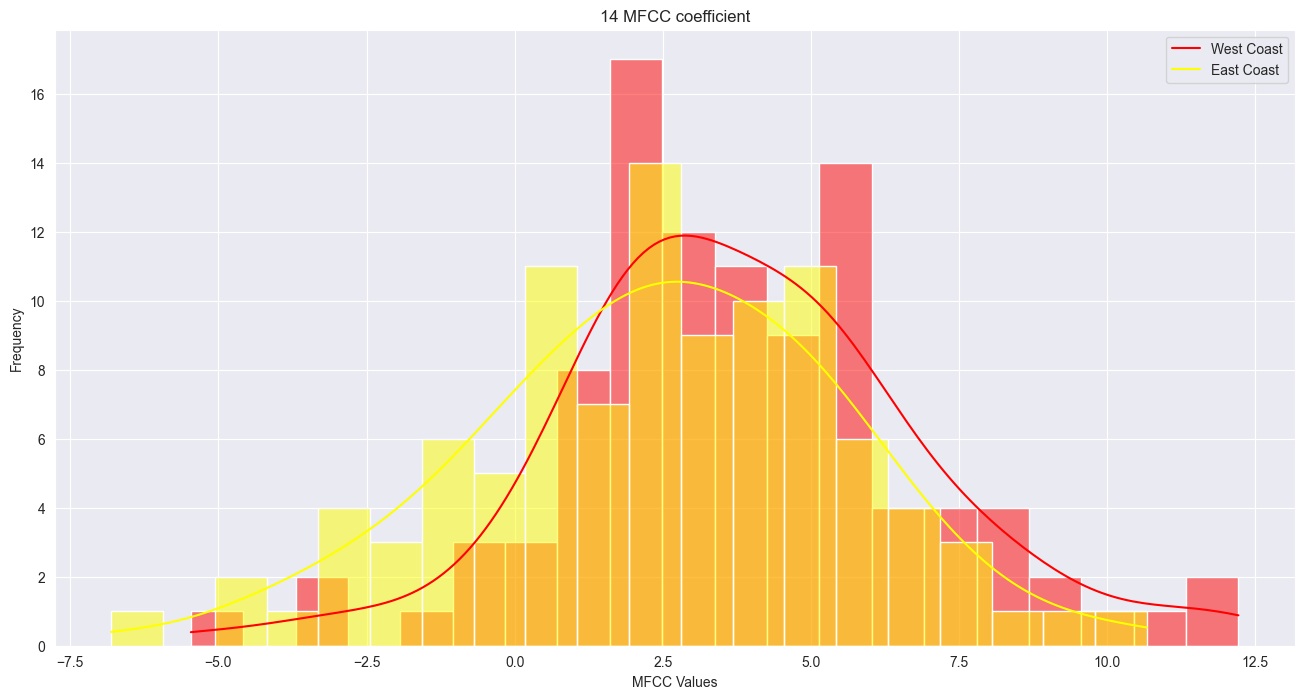

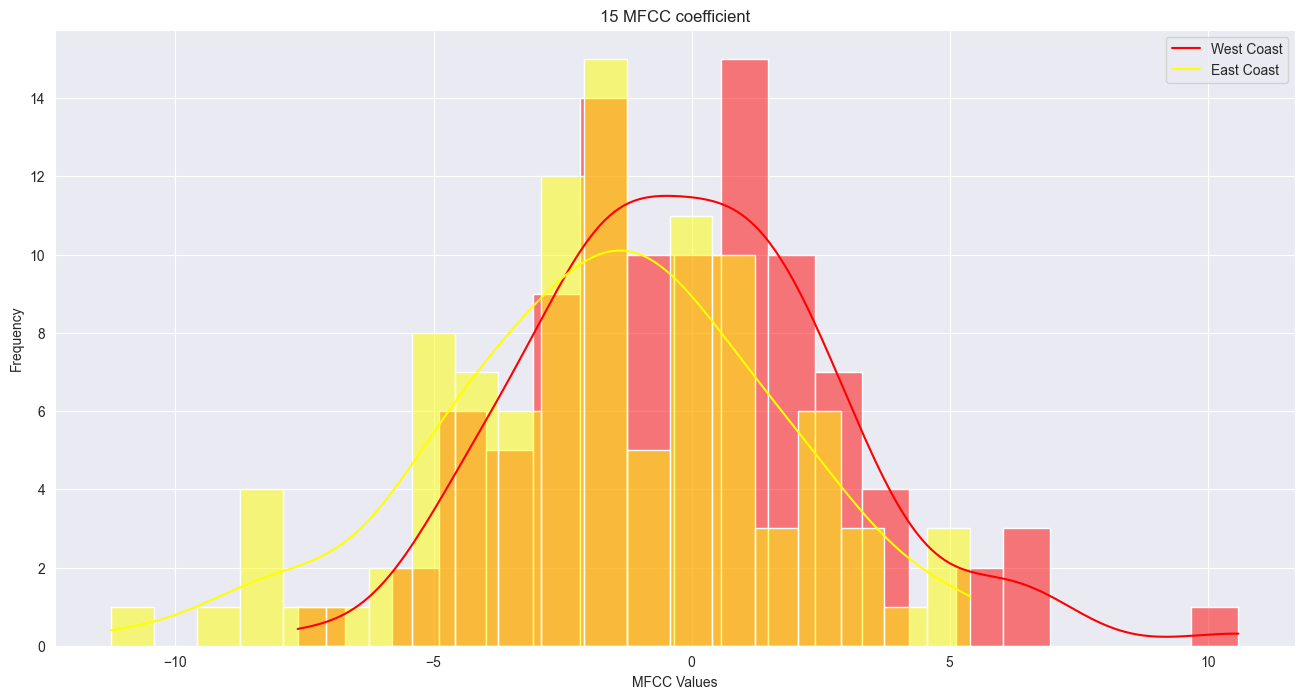

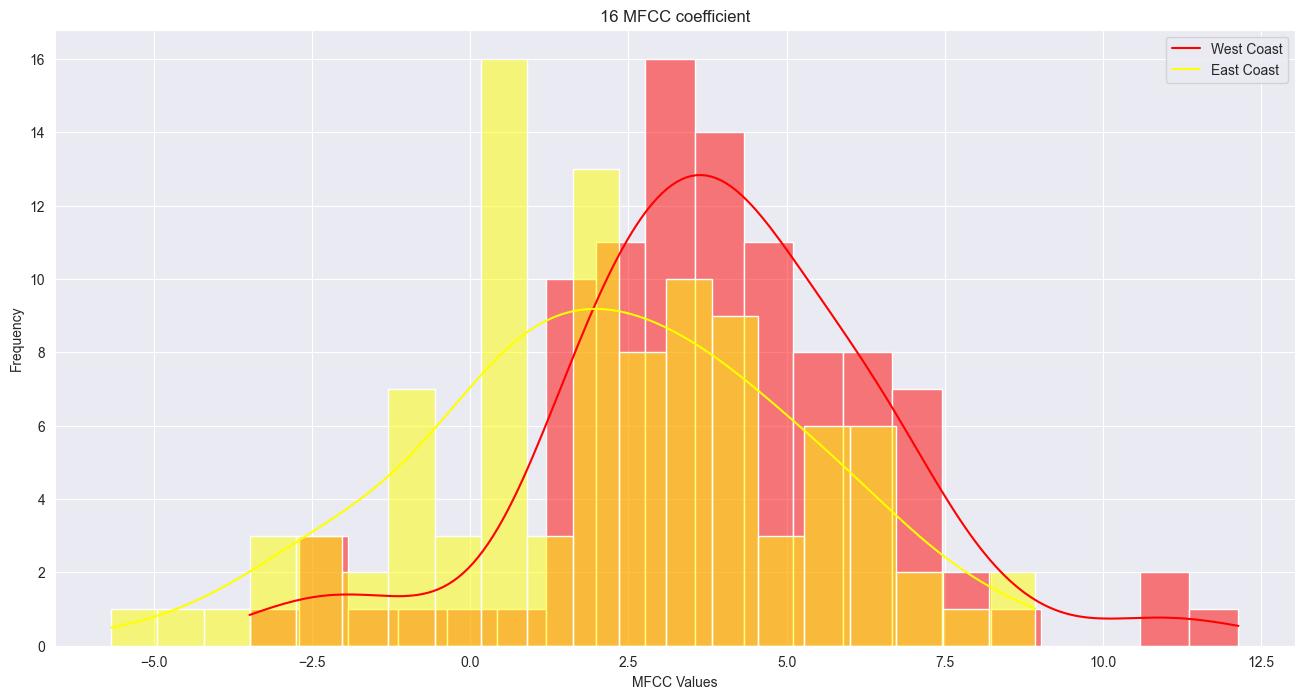

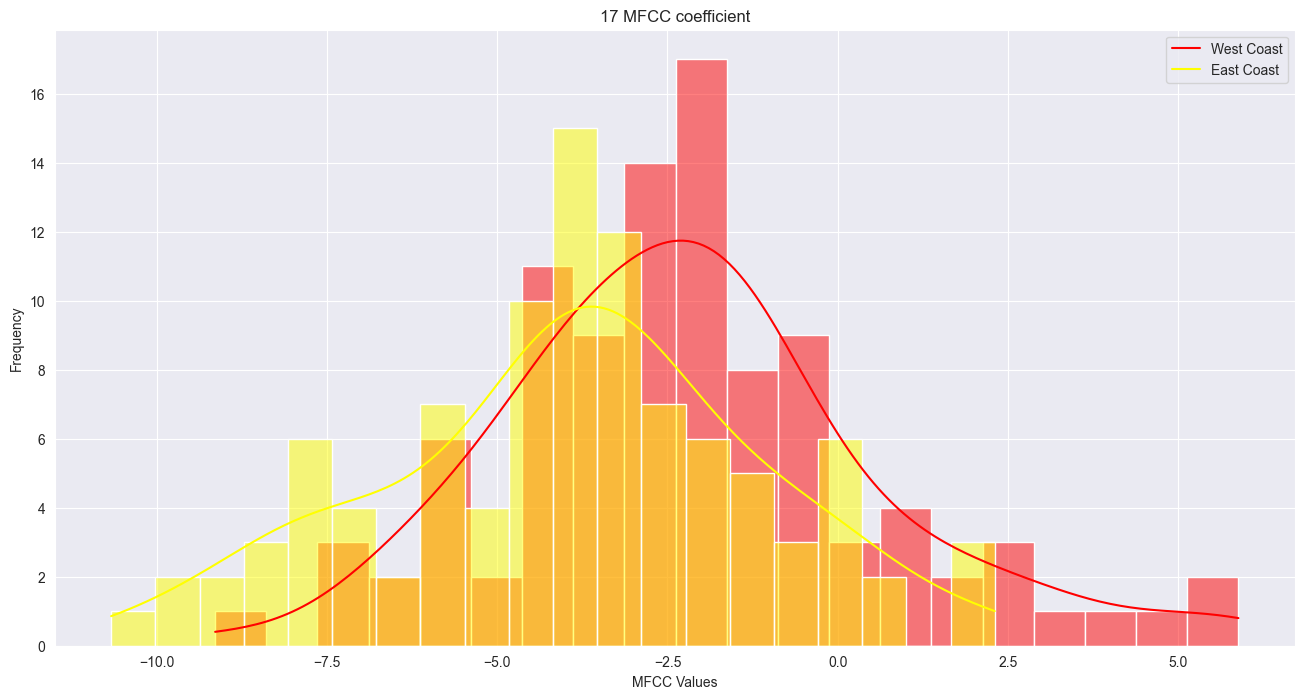

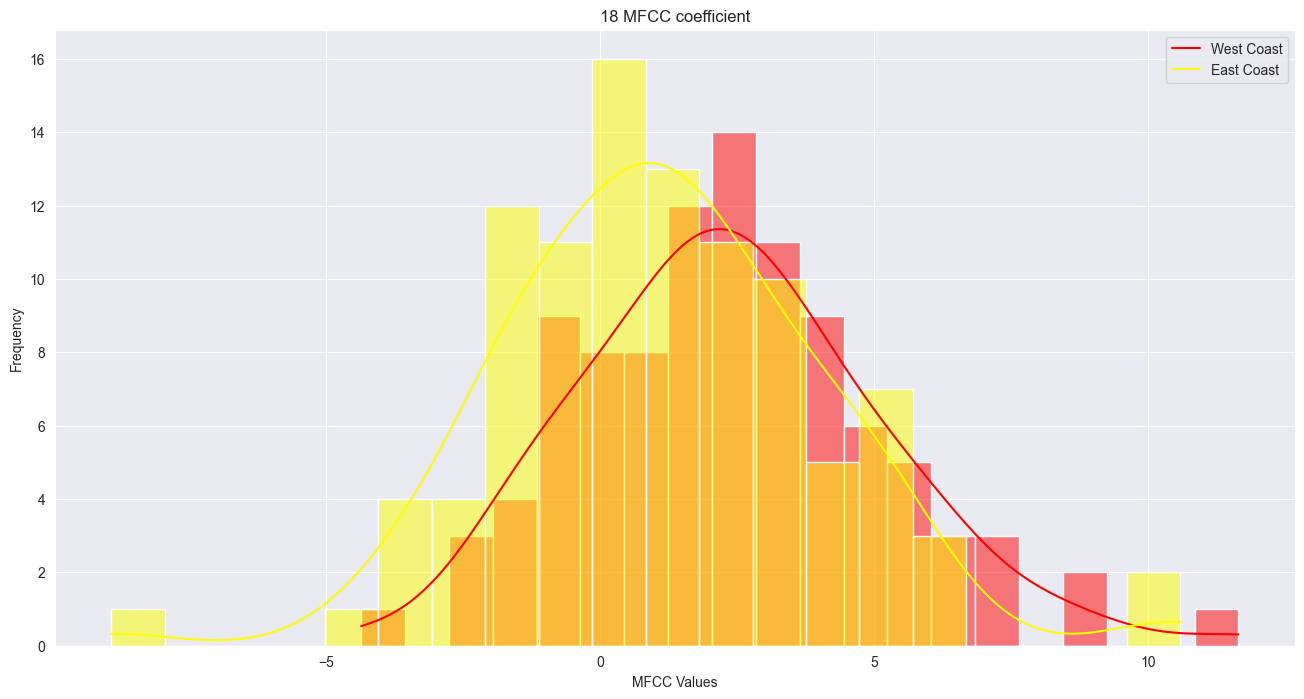

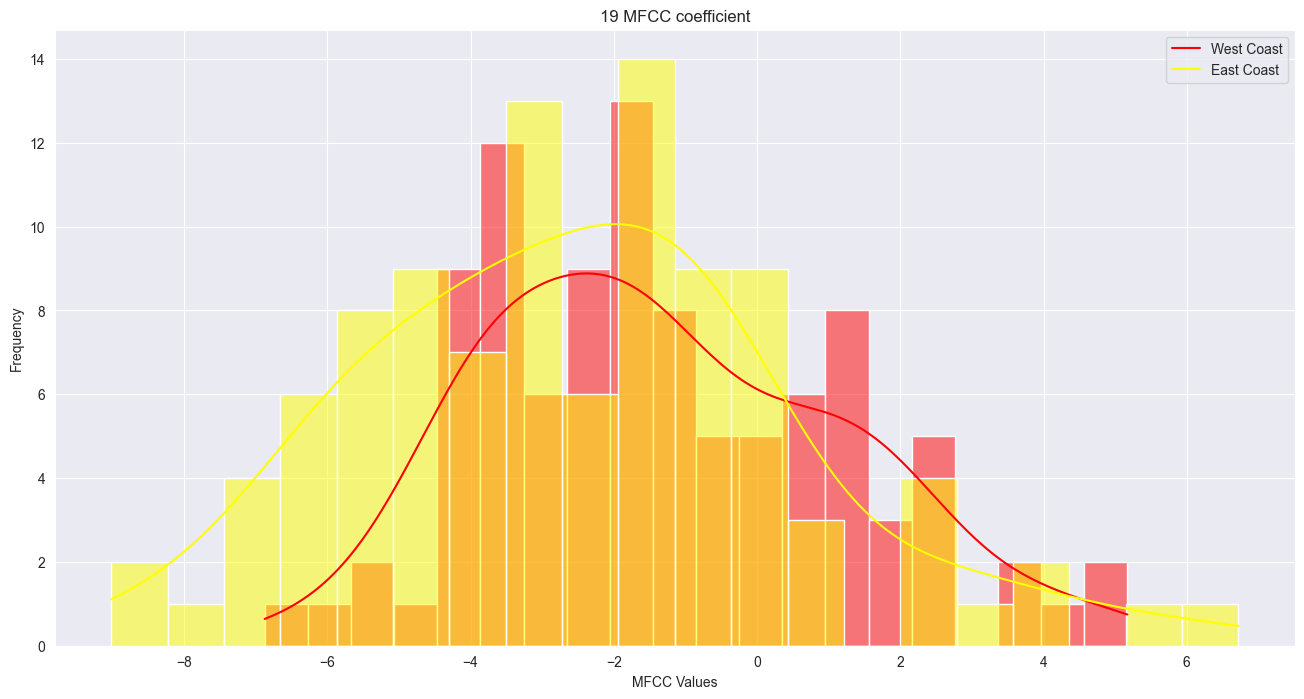

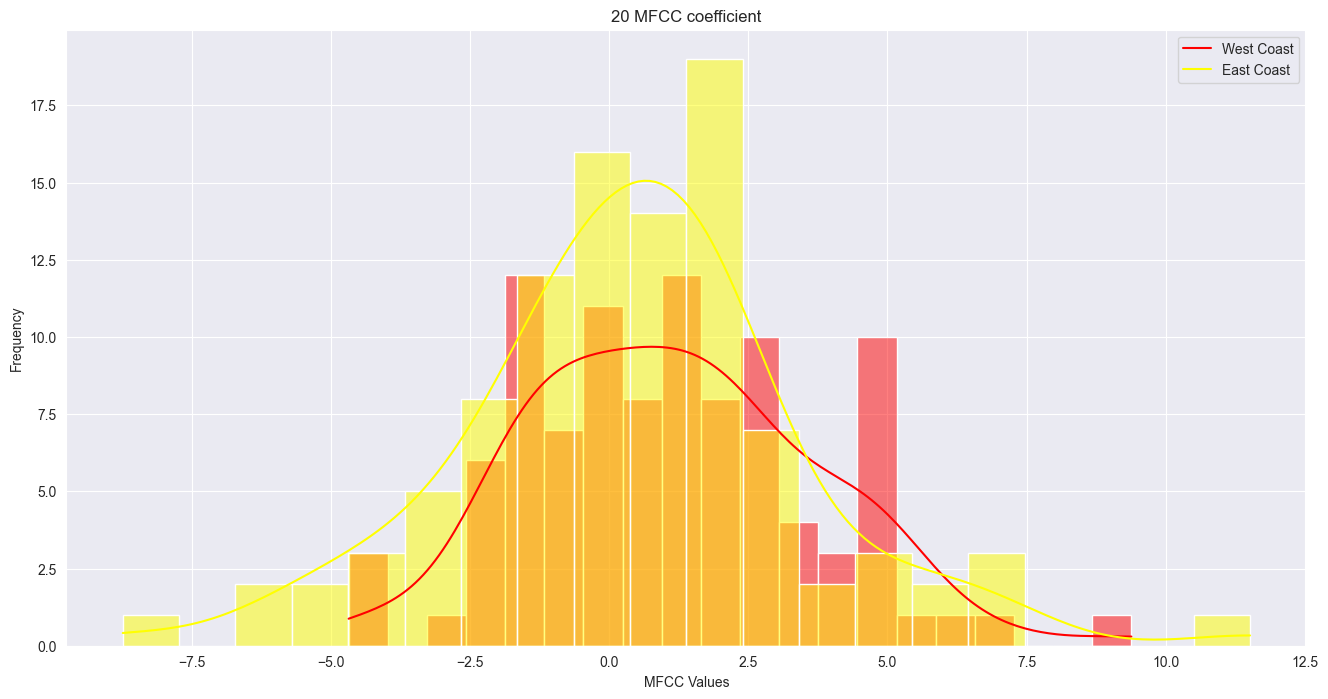

In [18]:
no_mfcc_component = east_coast_mfccs.shape[1]

for mfcc_coefficient in range(no_mfcc_component):
    plot_mfcc_distributions(west_coast_mfccs[:, mfcc_coefficient], east_coast_mfccs[:, mfcc_coefficient], ['West Coast', 'East Coast'], f'{mfcc_coefficient + 1} MFCC coefficient')